In [1]:
%matplotlib inline

In [2]:
import random
import pandas as pd
import numpy as np
import networkx as nx
import scipy.io as sio
import scipy.sparse as sp


from matplotlib import pyplot as plt
from helpers import (
    draw_edges, get_borderless_fig, pos_spring_layout, signed_layout, get_lcc, signed_normalized_laplacian, flatten,
    pos_adj, neg_adj
)
from core import query_graph_using_sparse_linear_solver, sweep_on_x_fast
from viz_helpers import draw_query_result
from stat_helpers import populate_fields, oppo, cohe, avg_pos_deg

In [3]:
def get_row_by_query(df, query):
    return df[df['query'] == query].iloc[0]

def show(g, df, q, prefix="", **kwargs):
    r = get_row_by_query(df, q)
    fig, ax = draw_query_result(g, r['C1'], r['C2'], show_query=True, r=r, **kwargs)
    ax.set_title('{} q:{}, agr:{:.2f}, ham:{:.2f}, beta: {:.2f}, opp:{:.2f}, coh:{:.2f}, max_posdeg:{:.2f}'.format(
        prefix, q, r['agreement'], r['ham'], r['best_beta'], r['opp'], r['coh'], r['max_posdeg']
    ))
    
def load_data(graph):
    g = nx.read_gpickle('graphs/{}.pkl'.format(graph))
    df = pd.read_pickle('outputs/{}_aug.pkl'.format(graph))
    return g, df            


In [4]:
graph = 'word'
g, df = load_data(graph)
df = df[df['k'] == 200]
A = nx.adj_matrix(g, weight='sign')

pos_A = pos_adj(A)
neg_A = neg_adj(A)
pos_g = nx.from_scipy_sparse_matrix(pos_A)

if not (pos_A.data == 1).all():
    pos_A.data = np.ones(pos_A.data.shape, dtype='float64')
if not (neg_A.data == 1).all():
    neg_A.data = np.ones(neg_A.data.shape, dtype='float64')

In [5]:
w2i = g.graph['w2i']
i2w = g.graph['i2w']

In [6]:
all_words = set(w2i.keys())

In [7]:
def pos_nbrs(word):
    s = g.graph['w2i'][word]
    return [g.graph['i2w'][n] for n in g.neighbors(s) if g[s][n]['sign'] > 0]

def neg_nbrs(word):
    s = g.graph['w2i'][word]
    return [g.graph['i2w'][n] for n in g.neighbors(s) if g[s][n]['sign'] < 0]

def get_words_string_from_indices(indices):
    return " ".join([g.graph['i2w'][i] for i in indices])

# polysemy "fair"

it has several meanings:

- treating people equally, in accordance with the rules or standards; legitimate
- considerable though not outstanding in size or amount.
- (of weather) fine and dry.
- a beautiful woman


# positive/negative neighbour of "fair"

In [8]:
print(' '.join(pos_nbrs('fair')))

light ordinary beautiful due medium modest fine delightful okay nice exposition sound honest clean clear right minimalist upright nondescript conservative nonpartisan pale limited lovely middling rational benefit tidy dainty moderate equitable generous temperate sweet good show square blonde cautious common equal commonplace celebration female feminine intermediate routine open inferior meet taking small white logical average


In [9]:
print(' '.join(neg_nbrs('fair')))

bad overcast foul extremist brunette great dirty steep heavy special dull dark grand poor awful terrible terrific exceptional far radical extreme rare raw male grotesque masculine bold partial cheating wonderful


In [10]:
def demo(seeds1, seeds2, n_labels_to_show=5):
    seeds1 = [w2i[w] for w in seeds1]
    seeds2 = [w2i[w] for w in seeds2]
    
    x, _ = query_graph_using_sparse_linear_solver(g, [seeds1, seeds2], kappa=0.9, verbose=0, ub=g.graph['lambda1'])

    C1, C2, C, best_t, best_sbr, ts, sbr_list = sweep_on_x_fast(g, x, top_k=100)

    # filter those in each side that are reachable in pos_g
    C1 = np.array(sorted(nx.dfs_preorder_nodes(pos_g.subgraph(C1), source=seeds1[0])))
    C2 = np.array(sorted(nx.dfs_preorder_nodes(pos_g.subgraph(C2), source=seeds2[0])))

    print(get_words_string_from_indices(C1))
    print('-' * 10)
    print(get_words_string_from_indices(C2))
    C1_to_show = np.random.choice(C1, size=np.minimum(n_labels_to_show, len(C1)), replace=False)
    C2_to_show = np.random.choice(C2, size=np.minimum(n_labels_to_show, len(C2)), replace=False)
    C1_labels = {i: i2w[i] for i in C1_to_show}
    C2_labels = {i: i2w[i] for i in C2_to_show}
    
    print('cohesion: ', oppo(pos_A, C1, C2))
    print('opposition: ', oppo(neg_A, C1, C2))
    print('avg pos deg: ', avg_pos_deg(pos_A, np.concatenate((C1, C2))))
    fig, ax = draw_query_result(
        g, C1, C2,
        seeds1=seeds1, seeds2=seeds2,
        C1_labels=C1_labels, C2_labels=C2_labels,
        layout='pos'
    )

# as  "treating people equally"

blonde fair faithful female feminine true trusty honest equitable
----------
cheating designing double-dealing foul lying dirty sly theft
cohesion:  0.0
opposition:  0.1527777777777778
avg pos deg:  2.3529411764705883


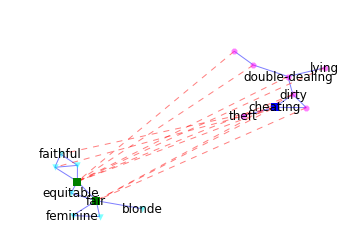

In [11]:
demo(['fair', 'honest'], ['cheating'])

# as meaning of "moderate" or "modest"

average blonde bridle cautious conservative fair female feminine intermediate limited medium middling minimalist moderate nondescript nonpartisan pacific chair inexpensive modest equitable mild temperate
----------
cheating extreme extremist fanatic far foul intensive overkill radical screaming steep terrorist utmost terrible terrific violent wonderful exceptional
cohesion:  0.0
opposition:  0.21980676328502413
avg pos deg:  6.0


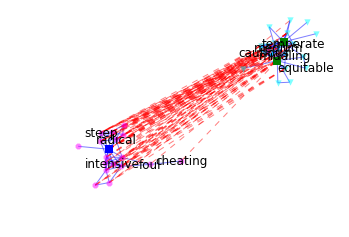

In [12]:
demo(['fair', 'moderate'], ['extreme'])

# as meaning of "beautiful female"

fair female feminine lady woman daughter
----------
chap gentleman guy male man masculine brother son
cohesion:  0.0
opposition:  0.2916666666666667
avg pos deg:  3.4285714285714284


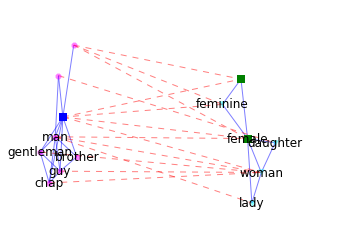

In [13]:
demo(['fair', 'female'], ['male'])